In [1]:
from flightdata import Flight, Fields
import numpy as np
import pandas as pd

logs = []
logs.append(Flight.from_log('./performance_Data/2020_11_24_hovering_climbs/climb_decent_low_hover.bin'))
#logs.append(Flight.from_log('./performance_Data/2020_11_24_hovering_climbs/hover_transitions.bin'))




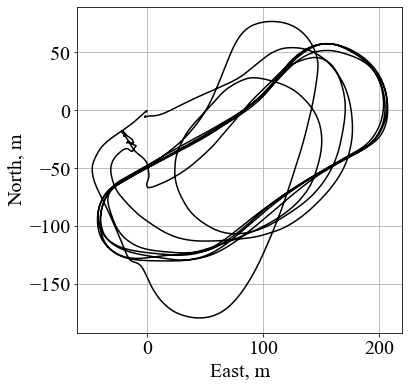

In [7]:
import matplotlib.pyplot as plt


def saveplot(name):
    plt.savefig(name + '.svg',bbox_inches='tight')

def matplotplot(width=6, height=6):
    plt.rcParams.update({
        'font.size' : 20,
        "font.family": 'Times New Roman',
        'mathtext.default': 'regular'
    }) 
    fig = plt.figure(figsize=(width, height))
    #fig.set_size_inches(10,3.54) 
    ax = fig.add_subplot(1,1,1)
    return (fig, ax)

def plot_ne_data(data):
    fig, ax = matplotplot(6, 6)
    ax.plot(data['position_y'], data['position_x'], color='black')
    ax.set_xlabel('East, m')
    ax.set_ylabel('North, m')
    ax.grid()
    ax.set_aspect('equal', 'box')

def plot_ne(log):
    plot_ne_data(log.read_fields(Fields.POSITION))


def setupgraph(width, height, xlabel, ylabels):
    plt.rcParams.update({
        'font.size' : 20,
        "font.family": 'Times New Roman',
        'mathtext.default': 'regular'
    }) 
    fig = plt.figure(figsize=(width, height))
    axes = []
    axes.append(fig.add_subplot(1,1,1))
    axes[0].set_ylabel(ylabels[0])
    lastpos = 1
    for label in ylabels[1:]:
        axes.append(axes[0].twinx())
        axes[-1].set_ylabel(label)
        axes[-1].spines['right'].set_position(('axes', lastpos))
        lastpos += 0.13
    return fig, axes 

def addlines(dfs, columns, axis, labels=None, colors=None, linewidths=None, factors=None):
    if not colors:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if not linewidths:
        linewidths = [0.75 for i in range(0, len(columns))]
    if not labels:
        labels = columns
    if not isinstance(axis, list):
        axes = [axis for i in range(0, len(columns))]
    else:
        axes = axis
    if factors is None:
        factors = [1 for i in range(0, len(columns))]

    for df in dfs:
        lns=[]
        for i in range(0, len(columns)):
            lns += axes[i].plot(factors[i] * df[columns[i]],  linewidth=linewidths[i], color=colors[i], label=labels[i])
    return lns
    
plot_ne(logs[0])



In [8]:
from FlightPerformance import DesignPoint
from apc_prop_reader import APCProp
from geometry import Point

buddi_prop = APCProp('PER3_20x13E')

buddi_light = DesignPoint()
buddi_light.mass = 11.66
buddi_light.pe = 0.325
buddi_light.cd0 = 0.03
buddi_light.Capacity = buddi_light.Capacity * 0.5
base_mass = 11.66


apc20x13 = APCProp('PER3_20x13E')


def get_thrust(U, accx, accz, aircraft, bmass=base_mass):
    aircraft.U = U
    aircraft.mass = - bmass * accz / 9.81
    drag_force = aircraft.q * aircraft.S * aircraft.cd
    acc_x_force = accx * bmass
    if acc_x_force < 0:
        acc_x_force=0
    #acc_x_force=0
    return drag_force + acc_x_force    

def get_power(U, thrust, pe):
    return thrust * U / pe

def get_endurance(power, aircraft):
    return ((aircraft.Voltage * aircraft.Capacity / power ) ** aircraft.n ) * aircraft.Rt ** (1 - aircraft.n)

def get_range(power, u, aircraft):
    return get_endurance(power, aircraft) * u

def get_airspeed(vx, vy, vz, vwx, vwy):
    return math.sqrt((vx-vwx)**2 + (vy-vwy)**2 + vz**2)



In [9]:
import math
import functools
from scipy.signal import butter,filtfilt
def generate_prediction(data, prop, aircraft, bmass=base_mass):
    '''predict the thrust, power, endurance and range based on the airspeed and load factor at every data point in the log'''
    
    data['airspeed'] = np.vectorize(get_airspeed)(data['velocity_x'], data['velocity_y'], data['velocity_z'], data['wind_x'], data['wind_y'])
    
    data['thrust'] = np.vectorize(get_thrust)(data['airspeed'], data['acceleration_x'], data['acceleration_z'], aircraft, bmass)
    #data['pe'] = prop.get_pe(np.array(data['airspeed_0']), 0.5 * np.array(data['thrust'])) * aircraft.pe
    
    data['pe'] = np.vectorize(prop.get_pe)(data['airspeed'], 0.5 * data['thrust']) * aircraft.pe
    data['prediction'] = np.vectorize(get_power)(data['airspeed'], data['thrust'], data['pe']) + 2
    
    data['endurance'] = np.vectorize(get_endurance)(np.array(data['prediction']), aircraft)
    data['range'] = np.vectorize(get_range)(np.array(data['prediction']), np.array(data['airspeed']),  aircraft)
    return data

def extract_performance_data(log, prop, aircraft, bmass=base_mass):
    '''make a dataframe for performance data comparisons'''
    
    data = log.read_fields([Fields.BATTERY, Fields.CURRENT, Fields.AIRSPEED, Fields.POSITION, Fields.VELOCITY, Fields.ACCELERATION, Fields.SERVOS, Fields.ATTITUDE, Fields.WIND, Fields.TXCONTROLS])

    data=data.loc[pd.isna(data['battery_0'])==False]
    data['power'] = data['battery_0'] * data['current_0'] + data['battery_1'] * data['current_1']
    
    return generate_prediction(data, prop, aircraft, bmass)
    
datas = []
datas.append(extract_performance_data(logs[0], apc20x13, buddi_light))
#datas.append(extract_performance_data(logs[1], apc20x13, buddi_light))

In [10]:

def plot_performance_data(data):

    fig, axes = setupgraph(12, 6, "Time, s", ['Altitude, m', 'Power, W', 'Airspeed, m/s'])
    
    lns = addlines(
        data, 
        ['position_z', 'power', 'prediction', 'airspeed'],
        [axes[0], axes[1], axes[1], axes[2]],
        ['Altitude', '$P_{measured}$', '$P_{prediction}$', 'U']
    )
    axes[0].legend(lns, [l.get_label() for l in lns], loc=4)


climbs = [
    [78, 90],
    [115, 125],
    [150, 163],
    [187, 200]
]
dives = [
    [60, 75],
    [95, 115],
    [130, 145],
    [170, 185]
]

def breakdata(data, intervals):
    broken = [data.loc[interval[0]:interval[1]] for interval in intervals]
    return [broke.set_index(broke.index - broke.index[0]) for broke in broken]



def climbsummary(climbdata):
    dlength = math.sqrt((climbdata.iloc[-1].position_x - climbdata.iloc[0].position_x) ** 2 + (climbdata.iloc[-1].position_y - climbdata.iloc[0].position_y) ** 2)
    dheight = climbdata.iloc[-1].position_z - climbdata.iloc[0].position_z

    climb_angle = math.atan(dheight / dlength) * 180 / math.pi
    climb_rate = dheight / (climbdata.index[-1] - climbdata.index[0])

    mean_power = climbdata.power.mean()
    mean_prediction = climbdata.prediction.mean()

    return climb_angle, climb_rate, mean_power, mean_prediction


climb_angle         -14.972721
climb_rate           -4.407979
mean_power         1925.280929
mean_prediction    2641.911380
dtype: float64

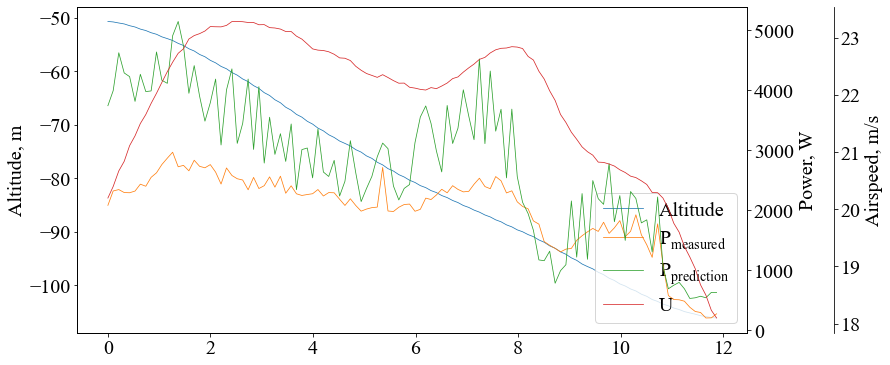

In [11]:

climbdata = breakdata(datas[0], climbs)
plot_performance_data([climbdata[0]])

climbsums = pd.DataFrame([climbsummary(climb) for climb in climbdata], columns = ['climb_angle', 'climb_rate', 'mean_power', 'mean_prediction'])
climbsums.mean()

climb_angle           9.737972
climb_rate            2.362908
mean_power          554.661663
mean_prediction    1117.250046
dtype: float64

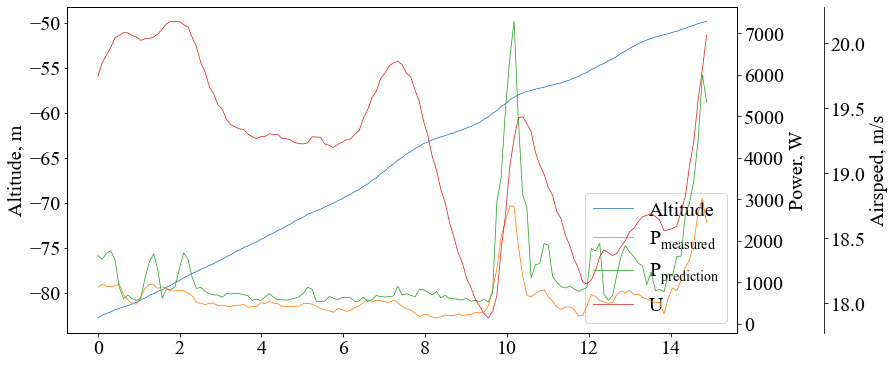

In [12]:

divedata = breakdata(datas[0], dives)
plot_performance_data([divedata[0]])

divesums = pd.DataFrame([climbsummary(dive) for dive in divedata], columns = ['climb_angle', 'climb_rate', 'mean_power', 'mean_prediction'])
divesums.mean()

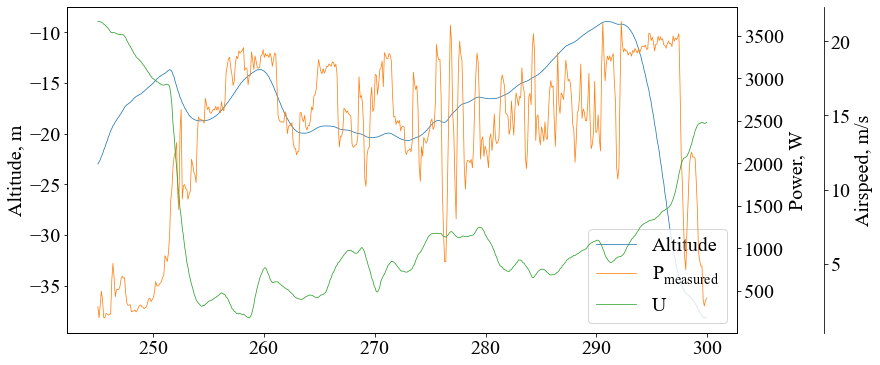

In [13]:
hoverdata = datas[0].loc[245:300]

fig, axes = setupgraph(12, 6, "Time, s", ['Altitude, m', 'Power, W', 'Airspeed, m/s'])

lns = addlines(
    [hoverdata], 
    ['position_z', 'power', 'airspeed'],
    [axes[0], axes[1], axes[2]],
    ['Altitude', '$P_{measured}$', 'U'],
    factors=[1, 1, 1]
)
axes[0].legend(lns, [l.get_label() for l in lns], loc=4)


In [14]:
print('Hover Power Required:',hoverdata.loc[260:290].mean().power, 'W')

Hover Power Required: 2602.60265884893 W


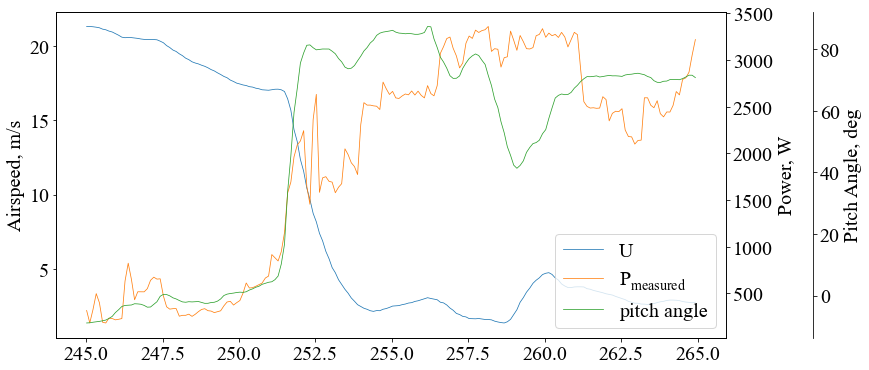

In [15]:
transition = datas[0].loc[245:265]

fig, axes = setupgraph(12, 6, "Time, s", ['Airspeed, m/s', 'Power, W', 'Pitch Angle, deg'])

lns = addlines(
    [transition], 
    ['airspeed', 'power', 'attitude_pitch'],
    [axes[0], axes[1], axes[2]],
    ['U', '$P_{measured}$', 'pitch angle'],
    factors=[1, 1, 180 / math.pi]
)
axes[0].legend(lns, [l.get_label() for l in lns], loc=4)


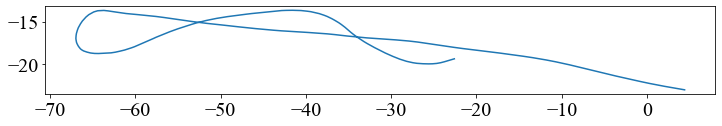

In [16]:
fig, ax = matplotplot(12, 6)
ax.plot(transition['position_x'], transition['position_z'])
ax.set_aspect('equal', 'box')

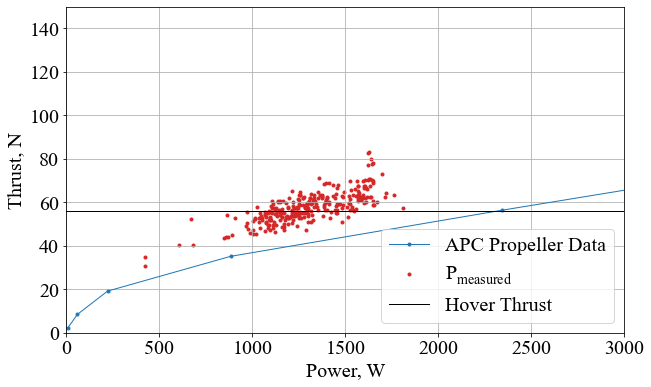

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

onehover = hoverdata[300:350]

prop_data = buddi_prop

dataIwant = prop_data.performance['V'] == 0

# expected power consumption based on steady level flight - hovering Throttle = W/2 (per motor)
weight = buddi_light.mass * 9.81

# plot
fig = plt.figure(figsize = (10, 6))
ax = plt.axes()

lns = []
lns += ax.plot(prop_data.performance[dataIwant].PWR, prop_data.performance[dataIwant].Thrust, label = 'APC Propeller Data', color='tab:blue', linewidth=1, marker=".")

lns.append(ax.scatter(hoverdata.loc[260:290].power/2, hoverdata.loc[260:290]['thrust']/2, label = '$P_{measured}$', color='tab:red', marker="."))

lns += [ax.axhline(weight / 2, 0, 100, label = 'Hover Thrust', linewidth=1, color='black')]
#lns += [ax.axhline((weight + 3.445*9.81) / 2, 0, 100, label = 'STOL Hover Thrust', linewidth=1, color='black', linestyle='--')]
#lns += [ax.axvline(2800, 0, 100, label = '$P_{max}$', linewidth=1, color='black', linestyle='-.')]

ax.grid('both')
ax.legend(lns, [l.get_label() for l in lns], loc=4)
ax.set_xlabel('Power, W')
ax.set_ylabel('Thrust, N')
ax.set_xlim(0, 3000)
ax.set_ylim(0, 150)

plt.xticks(visible=True)
plt.yticks(visible=True)

plt.draw()

saveplot('buddita_hover_power')